# Plot various distributions of mutated position information

In [1]:
%run "Header.ipynb"
import pickle
from linked_mutations_utils import find_mutated_positions

## Compute info

In [56]:
# In all of these three dicts, each seq points to a list where each value is from one
# pair of consecutive mutated positions.

# Describes distances between positions.
seq2dists = {}

# Describes number of reads supporting the most common nucleotide pair at these positions.
seq2reads = {}

# Describes link value of this most common nucleotide pair at these positions.
seq2links = {}

for i, seq in enumerate(SEQS):
    print(f"Computing distribution info for seq {seq2name[seq]}...")
    
    print(f"\tFinding mutated positions for seq {seq2name[seq]}...", end=" ", flush=True)
    mutated_positions = find_mutated_positions(seq)
    print("Done.")
    
    with open(f"phasing-data/{seq}_pospair2ntpair2freq.pickle", "rb") as loadster:
        pospair2ntpair2freq = pickle.load(loadster)
        
    with open(f"phasing-data/{seq}_pos2nt2freq.pickle", "rb") as loadster:
        pos2nt2freq = pickle.load(loadster)
    
    seq2dists[seq] = []
    seq2reads[seq] = []
    seq2links[seq] = []
    
    print(f"\tLooking through pairs of consecutive mutated positions in seq {seq2name[seq]}...")
    
    for mpi, left_mutpos in enumerate(mutated_positions):
        if mpi == len(mutated_positions) - 1:
            if seq in ("edge_2358", "edge_1671"):
                # Loop around the genome if it's a circular sequence.
                # Edge 6104 is excluded from this because it's just a linear sequence --
                # its full "genome" likely has not been completely assembled.
                #
                # Note that although the reads here probably go from left_mutpos -> mutated_positions[0], we
                # sort these positions the other way in this pair because the pairs are stored in sorted order.
                pospair = (mutated_positions[0], left_mutpos)

                # NOTE: mutated_positions, as with pospair2ntpair2freq, uses 0-indexed positions.
                # I don't thiiiink it makes a difference here (since in e.g. (p + x) - (p + x + 5), the x's
                # representing 1-indexing cancel out), though.
                #
                # This holds up under scrutiny of some examples: in the case where left_mutpos is the
                # actual last position (not just the last mutated position, the last POSITION) in the
                # genome (before looping), and mutated_positions[0] is similarly the first POSITION in
                # the genome, the distance is (length + 0 - (length - 1)) = 1.
                dist = seq2len[seq] + mutated_positions[0] - left_mutpos
            else:
                # If we are at the "final" (rightmost) mutated position, and we're not in a circular sequence,
                # then we don't bother trying to analyze a new pair of mutated positions where this one is
                # the leftmost. We just move on.
                break
        else:
            pospair = (left_mutpos, mutated_positions[mpi + 1])
            dist = mutated_positions[mpi + 1] - left_mutpos
            
        seq2dists[seq].append(dist)
        
        if pospair in pospair2ntpair2freq:
            # flag weird stuff (and prove that consecutive mutated positions separated by large distances,
            # e.g. the ones that are ~40kbp apart shown in the histograms below, aren't observed on the same read)
            if dist > 20000:
                print(
                    f"\t\tPos pair of ({pospair[0]:,}, {pospair[1]:,}) is {dist:,} bp apart, and observed together!"
                )
            max_freq_nt_pair = max(
                pospair2ntpair2freq[pospair].keys(),
                key=lambda ntpair: pospair2ntpair2freq[pospair][ntpair]
            )
            pair_reads = pospair2ntpair2freq[pospair][max_freq_nt_pair]
            seq2reads[seq].append(pair_reads)
            
            allele_1_freq = pos2nt2freq[pospair[0]][max_freq_nt_pair[0]]
            allele_2_freq = pos2nt2freq[pospair[1]][max_freq_nt_pair[1]]
            # Computation is done the same way as when adding link data to the graph in the previous phasing ntbk
            # I'm pretty dang sure that the denominator here can never be zero, b/c that would imply neither of
            # these alleles were observed in a read and we KNOW that can't be the case
            # ...but if this turns into a ZeroDivisionError in the future, feel free to send me an angry email 
            link = pair_reads / max(allele_1_freq, allele_2_freq)
            seq2links[seq].append(link)
        else:
            # This pair was never seen together on the same read :(
            seq2reads[seq].append(0)
            seq2links[seq].append(0)
    print(f"\tDone with {seq2name[seq]}.")

with open(f"phasing-data/seq2dists.pickle", "wb") as dumpster:
    dumpster.write(pickle.dumps(seq2dists))
            
with open(f"phasing-data/seq2reads.pickle", "wb") as dumpster:
    dumpster.write(pickle.dumps(seq2reads))
    
with open(f"phasing-data/seq2links.pickle", "wb") as dumpster:
    dumpster.write(pickle.dumps(seq2links))

Computing distribution info for seq CAMP...
	Finding mutated positions for seq CAMP... Done.
	Looking through pairs of consecutive mutated positions in seq CAMP...
		Pos pair of (264,066, 285,045) is 20,979 bp apart, and observed together!
		Pos pair of (493,265, 515,383) is 22,118 bp apart, and observed together!
		Pos pair of (578,184, 598,364) is 20,180 bp apart, and observed together!
		Pos pair of (684,175, 705,448) is 21,273 bp apart, and observed together!
		Pos pair of (857,547, 878,617) is 21,070 bp apart, and observed together!
	Done with CAMP.
Computing distribution info for seq BACT1...
	Finding mutated positions for seq BACT1... Done.
	Looking through pairs of consecutive mutated positions in seq BACT1...
	Done with BACT1.
Computing distribution info for seq BACT2...
	Finding mutated positions for seq BACT2... Done.
	Looking through pairs of consecutive mutated positions in seq BACT2...
	Done with BACT2.


### Load info, so we can skip re-computing if desired

In [44]:
with open(f"phasing-data/seq2dists.pickle", "rb") as loadster:
    seq2dists = pickle.load(loadster)
    
with open(f"phasing-data/seq2reads.pickle", "rb") as loadster:
    seq2reads = pickle.load(loadster)

with open(f"phasing-data/seq2links.pickle", "rb") as loadster:
    seq2links = pickle.load(loadster)

## Plot info


Between any two consecutive mutated positions, i and j:
	Maximum distance: 46,145 bp
	Maximum reads(i, j, Ni, Nj) (only considering max-freq nt pairs): 4,831x
	Maximum link(i, j, Ni, Nj) (only considering max-freq nt pairs): 1.0


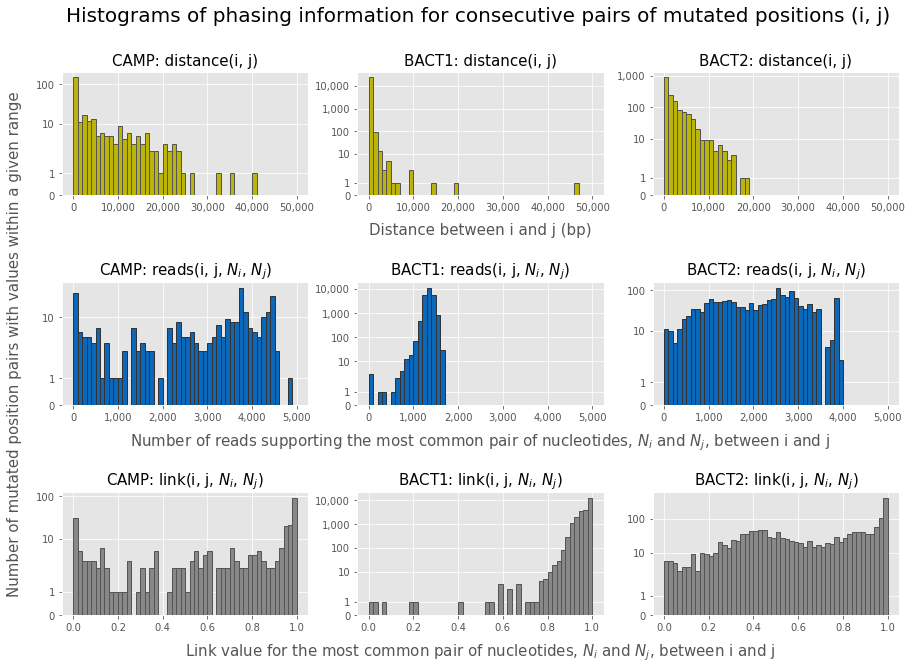

In [53]:
fig, axes = pyplot.subplots(3, 3, gridspec_kw={"hspace": 0.7})

# 3x3 plot
# columns = sequences (CAMP, BACT1, BACT2)
# rows = different distributions (dist(i, j), reads(i, j, Ni, Nj), link(i, j, Ni, Nj))


# Compute some stats to help with setting x limits
max_dist = float("-inf")
max_reads = float("-inf")
max_link = float("-inf")
for seq in SEQS:
    for d in seq2dists[seq]:
        max_dist = max(max_dist, d)
    for r in seq2reads[seq]:
        max_reads = max(max_reads, r)
    for l in seq2links[seq]:
        max_link = max(max_link, l)
print("Between any two consecutive mutated positions, i and j:")
print(f"\tMaximum distance: {max_dist:,} bp")
print(f"\tMaximum reads(i, j, Ni, Nj) (only considering max-freq nt pairs): {max_reads:,}x")
print(f"\tMaximum link(i, j, Ni, Nj) (only considering max-freq nt pairs): {max_link:}")

for si, seq in enumerate(SEQS):
    # NOTE: The maximum x is set based on the maximum distance observed (see: the stuff
    # we just printed out). Ideally we'd figure out this value programmatically and store it,
    # like in the div idx notebook, but this approach is good enough since i probably won't be
    # reusing this code on new data any time soon
    axes[0, si].hist(
        seq2dists[seq], color="#bab40b", linewidth=1, edgecolor="#555555",
        bins=[x * 1000 for x in range(0, 51)]
    )
    axes[0, si].set_title(f"{seq2name[seq]}: distance(i, j)", fontsize=15)
    
    # Bins selected here cover all coverages from 0x to 5,000x, which is good enough for us
    axes[1, si].hist(
        seq2reads[seq], color="#0b67b8", linewidth=1, edgecolor="#333333",
        bins=[x * 100 for x in range(0, 51)]
    )
    axes[1, si].set_title(f"{seq2name[seq]}: reads(i, j, $N_i$, $N_j$)", fontsize=15)
    
    # We just need to cover all links in the range [0, 1] -- this already happens by default,
    # but we use the bins parameter here to get more granularity. We use a step size of 2 (so
    # the bins are [0.01, 0.02), then [0.02, 0.04), etc...) in order to have roughly the same
    # amount of bins, ~50, as the above two plots. (Using a step size of 1 here results in the
    # bins in this row looking very tiny, IMO.)
    axes[2, si].hist(
        seq2links[seq], color="#888888", linewidth=1, edgecolor="#555555",
        bins=[x / 100 for x in range(0, 101, 2)]
    )
    axes[2, si].set_title(f"{seq2name[seq]}: link(i, j, $N_i$, $N_j$)", fontsize=15)
    
    for ri in (0, 1, 2):
        axes[ri, si].set_yscale("symlog")
        axes[ri, si].yaxis.set_major_formatter("{x:,.0f}")
        
        if ri != 2:
            axes[ri, si].xaxis.set_major_formatter("{x:,.0f}")

axes[1, 0].set_ylabel(
    "Number of mutated position pairs with values within a given range",
    labelpad=20,
    fontsize=15
)

axes[0, 1].set_xlabel(
    "Distance between i and j (bp)", fontsize=15, labelpad=10
)

axes[1, 1].set_xlabel(
    "Number of reads supporting the most common pair of nucleotides, $N_i$ and $N_j$, between i and j", fontsize=15, labelpad=10
)

axes[2, 1].set_xlabel(
    "Link value for the most common pair of nucleotides, $N_i$ and $N_j$, between i and j", fontsize=15, labelpad=10
)


fig.suptitle(
    "Histograms of phasing information for consecutive pairs of mutated positions (i, j)",
    fontsize=20,
    y=0.97,
    x=0.51
)
fig.set_size_inches(15, 10)
fig.savefig(f"figs/phasing-stat-hists.png", bbox_inches="tight")